# Importing Libraries

In [1]:
! pip install lifelines

import json
import pickle
import keras
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import sys, re, math, time
import matplotlib.pyplot as plt
import random
import gc
from tqdm import tqdm
from keras import optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, Dense, Flatten, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dropout, Activation
from keras.models import Model
from keras.utils import plot_model
from lifelines.utils import concordance_index
from collections import OrderedDict
from matplotlib.pyplot import cm
from sklearn.model_selection import KFold

# Unique characters for FASTA
char_fasta = {'V', 'L', 'N', '9', 'M', '8', '7', 'C', 'H', 'P', '4', 'W', '5', '0', '2', 'X', 'Y', 'S', 'E', '3', 'I', 'G', 'A', 'U', '1', 'R', 'F', '6', 'K', 'D', 'T', 'Q'}
code_fasta = {i+1 for i in range(len(char_fasta))}
CHARPROTSET = dict(zip(char_fasta, code_fasta))
print(len(CHARPROTSET))
print(CHARPROTSET)

# Unique characters for SMILES
char_smiles = {'@', ':', 'Z', 'V', 'u', 'L', '.', 'N', 'O', '9', 'd', 'g', 's', 'M', ']', '8', 'c', 'o', 't', '7', 'C', 'H', '-', 'P', '4', 'e', 'a', 'i', '5', '/', '0', '2', '%', 'n', 'S', 'B', '3', 'r', 'I', '#', ')', '=', 'A', '1', '(', 'R', 'b', 'F', 'l', '6', 'K', '[', 'T', '+', '\\'}
code_smiles = {i+1 for i in range(len(char_smiles))}
CHARISOSMISET = dict(zip(char_smiles, code_smiles))
print(len(CHARISOSMISET))
print(CHARISOSMISET)

smilen = 95
seqlen = 1000

charsmiset_size = len(CHARISOSMISET)
charseqset_size = len(CHARPROTSET)

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

32
{'M': 1, 'R': 2, 'D': 3, 'L': 4, 'A': 5, 'K': 6, 'Q': 7, 'P': 8, 'X': 9, 'F': 10, 'Y': 11, '6': 12, 'E': 13, 'H': 14, '2': 15, 'G': 16, '1': 17, '5': 18, 'N': 19, '3': 20, '0': 21, '9': 22, 'V': 23, 'T': 24, '4': 25, 'W': 26, 'C': 27, 'I': 28, '8': 29, 'S': 30, 'U': 31, '7': 32}
55
{'M': 1, ':': 2, 'R': 3, 'O': 4, 'L': 5, 'n': 6, 'b': 7, 'A': 8, 'K': 9, '+': 10, 'r': 11, '/': 12, 'P': 13, '#': 14, 'F': 15, 'u': 16, 'o': 17, '%': 18, '.': 19, '(': 20, 'H': 21, 'g': 22, 'l': 23, '2': 24, '1': 25, 'S': 26, '5': 27, 't': 28, 'e': 29, 'N': 30, '-': 31, '3': 32, '0': 33, '9': 34, 'c': 35, 'V': 36, ']': 37, 'T': 38, 'i': 39, '4': 40, 's': 41, '[': 42, '\\': 43, '=': 44, '@': 45, 'C': 46, 'd': 47, 'I': 48, ')': 49, 'a': 50, 'B': 51, '8': 52, 'Z': 53, '6': 54, '7': 55}


# Data Preparation

## Download The Data

In [ ]:
! wget https://www.bindingdb.org/bind/downloads/BindingDB_All_2021m0.tsv.zip
! unzip BindingDB_All_2021m0.tsv.zip
! rm BindingDB_All_2021m0.tsv.zip
! ls

--2021-02-20 06:38:00--  https://www.bindingdb.org/bind/downloads/BindingDB_All_2021m0.tsv.zip
Resolving www.bindingdb.org (www.bindingdb.org)... 137.110.139.247
Connecting to www.bindingdb.org (www.bindingdb.org)|137.110.139.247|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 369193761 (352M) [application/zip]
Saving to: ‘BindingDB_All_2021m0.tsv.zip’

BindingDB_All_2021m 100%[===================>] 352.09M  8.68MB/s    in 41s     

2021-02-20 06:38:42 (8.55 MB/s) - ‘BindingDB_All_2021m0.tsv.zip’ saved [369193761/369193761]

Archive:  BindingDB_All_2021m0.tsv.zip
  inflating: BindingDB_All.tsv       
BindingDB_All.tsv  drive  sample_data


## Load the data

In [ ]:
df = pd.read_csv('BindingDB_All.tsv', sep='\t', error_bad_lines=False)
df.head()

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name Assigned by Curator or DataSource,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,Temp (C),Curation/DataSource,Article DOI,PMID,PubChem AID,Patent Number,Authors,Institution,Link to Ligand in BindingDB,Link to Target in BindingDB,Link to Ligand-Target Pair in BindingDB,Ligand HET ID in PDB,PDB ID(s) for Ligand-Target Complex,PubChem CID,PubChem SID,ChEBI ID of Ligand,ChEMBL ID of Ligand,DrugBank ID of Ligand,IUPHAR_GRAC ID of Ligand,KEGG ID of Ligand,ZINC ID of Ligand,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,PDB ID(s) of Target Chain,UniProt (SwissProt) Recommended Name of Target Chain,...,UniProt (TrEMBL) Entry Name of Target Chain.9,UniProt (TrEMBL) Primary ID of Target Chain.9,UniProt (TrEMBL) Secondary ID(s) of Target Chain.9,UniProt (TrEMBL) Alternative ID(s) of Target Chain.9,BindingDB Target Chain Sequence.10,PDB ID(s) of Target Chain.10,UniProt (SwissProt) Recommended Name of Target Chain.10,UniProt (SwissProt) Entry Name of Target Chain.10,UniProt (SwissProt) Primary ID of Target Chain.10,UniProt (SwissProt) Secondary ID(s) of Target Chain.10,UniProt (SwissProt) Alternative ID(s) of Target Chain.10,UniProt (TrEMBL) Submitted Name of Target Chain.10,UniProt (TrEMBL) Entry Name of Target Chain.10,UniProt (TrEMBL) Primary ID of Target Chain.10,UniProt (TrEMBL) Secondary ID(s) of Target Chain.10,UniProt (TrEMBL) Alternative ID(s) of Target Chain.10,BindingDB Target Chain Sequence.11,PDB ID(s) of Target Chain.11,UniProt (SwissProt) Recommended Name of Target Chain.11,UniProt (SwissProt) Entry Name of Target Chain.11,UniProt (SwissProt) Primary ID of Target Chain.11,UniProt (SwissProt) Secondary ID(s) of Target Chain.11,UniProt (SwissProt) Alternative ID(s) of Target Chain.11,UniProt (TrEMBL) Submitted Name of Target Chain.11,UniProt (TrEMBL) Entry Name of Target Chain.11,UniProt (TrEMBL) Primary ID of Target Chain.11,UniProt (TrEMBL) Secondary ID(s) of Target Chain.11,UniProt (TrEMBL) Alternative ID(s) of Target Chain.11,BindingDB Target Chain Sequence.12,PDB ID(s) of Target Chain.12,UniProt (SwissProt) Recommended Name of Target Chain.12,UniProt (SwissProt) Entry Name of Target Chain.12,UniProt (SwissProt) Primary ID of Target Chain.12,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
0,1,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,InChI=1S/C22H24BrFN4O2/c1-28-7-5-14(6-8-28)12-...,UHTHHESEBZOYNR-UHFFFAOYSA-N,21,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",HIV-1 Protease,Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,Curated from the literature by BindingDB,10.1021/jm9602571,8.78445e+06,NaN,NaN,"Lam, PY; Ru, Y; Jadhav, PK; Aldrich, PE; DeLuc...",DuPont Pharmaceuticals Company,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/jsp/dbsearch/PrimaryS...,http://www.bindingdb.org/jsp/dbsearch/PrimaryS...,ZD6,2IVU,3081361.0,8030012.0,49960.0,CHEMBL24828,DB08764,NaN,NaN,ZINC03834198,1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"1D4H,1D4I,1D4J,1DIF,1EBW,1EBZ,1EC0,1EC1,1EC2,1...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",HIV-1 Protease,Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,C

In [ ]:
# Dataset awal
df.shape

(2077357, 193)

## Data reduction and preprocessing

In [ ]:
df = df[df['Ki (nM)'].notnull()]
df.shape

(480447, 193)

In [ ]:
# Menghilangkan baris yang tidak pakai nilai asli 
np.random.seed(42)

def remove_comparison_ki(x):
  x = re.sub(r'[>=<]+.+', '', x)
  return x

def normalize_format_ki(x):
  x = '%f' % (float(x))
  return x

df['Ki (nM)'] = df['Ki (nM)'].astype(str).apply(remove_comparison_ki)
df['Ki (nM)'] = df['Ki (nM)'].replace('', np.nan)
df['Ki (nM)'] = df['Ki (nM)'].apply(normalize_format_ki)
df['Ki (nM)'] = df['Ki (nM)'].astype('float')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480447 entries, 0 to 2077228
Columns: 193 entries, BindingDB Reactant_set_id to UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
dtypes: float64(91), int64(3), object(99)
memory usage: 711.1+ MB


In [ ]:
df.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_original.tsv', sep='\t', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_original.tsv', sep='\t')
print(df.shape)
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,11,15,17,19,20,32,34,49,50,51,52,53,54,61,62,63,64,65,66,73,74,75,76,77,78,85,86,87,88,89,90,97,98,99,100,101,102,109,110,111,112,113,114,121,122,123,124,125,126,133,134,135,136,137,138,145,147,148,149,150,157,158,159,160,161,162,169,171,172,173,174) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(480447, 193)


,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name Assigned by Curator or DataSource,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,Temp (C),Curation/DataSource,Article DOI,PMID,PubChem AID,Patent Number,Authors,Institution,Link to Ligand in BindingDB,Link to Target in BindingDB,Link to Ligand-Target Pair in BindingDB,Ligand HET ID in PDB,PDB ID(s) for Ligand-Target Complex,PubChem CID,PubChem SID,ChEBI ID of Ligand,ChEMBL ID of Ligand,DrugBank ID of Ligand,IUPHAR_GRAC ID of Ligand,KEGG ID of Ligand,ZINC ID of Ligand,Number of Protein Chains in Target (>1 implies a multichain complex),BindingDB Target Chain Sequence,PDB ID(s) of Target Chain,UniProt (SwissProt) Recommended Name of Target Chain,...,UniProt (TrEMBL) Entry Name of Target Chain.9,UniProt (TrEMBL) Primary ID of Target Chain.9,UniProt (TrEMBL) Secondary ID(s) of Target Chain.9,UniProt (TrEMBL) Alternative ID(s) of Target Chain.9,BindingDB Target Chain Sequence.10,PDB ID(s) of Target Chain.10,UniProt (SwissProt) Recommended Name of Target Chain.10,UniProt (SwissProt) Entry Name of Target Chain.10,UniProt (SwissProt) Primary ID of Target Chain.10,UniProt (SwissProt) Secondary ID(s) of Target Chain.10,UniProt (SwissProt) Alternative ID(s) of Target Chain.10,UniProt (TrEMBL) Submitted Name of Target Chain.10,UniProt (TrEMBL) Entry Name of Target Chain.10,UniProt (TrEMBL) Primary ID of Target Chain.10,UniProt (TrEMBL) Secondary ID(s) of Target Chain.10,UniProt (TrEMBL) Alternative ID(s) of Target Chain.10,BindingDB Target Chain Sequence.11,PDB ID(s) of Target Chain.11,UniProt (SwissProt) Recommended Name of Target Chain.11,UniProt (SwissProt) Entry Name of Target Chain.11,UniProt (SwissProt) Primary ID of Target Chain.11,UniProt (SwissProt) Secondary ID(s) of Target Chain.11,UniProt (SwissProt) Alternative ID(s) of Target Chain.11,UniProt (TrEMBL) Submitted Name of Target Chain.11,UniProt (TrEMBL) Entry Name of Target Chain.11,UniProt (TrEMBL) Primary ID of Target Chain.11,UniProt (TrEMBL) Secondary ID(s) of Target Chain.11,UniProt (TrEMBL) Alternative ID(s) of Target Chain.11,BindingDB Target Chain Sequence.12,PDB ID(s) of Target Chain.12,UniProt (SwissProt) Recommended Name of Target Chain.12,UniProt (SwissProt) Entry Name of Target Chain.12,UniProt (SwissProt) Primary ID of Target Chain.12,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
0,1,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,InChI=1S/C22H24BrFN4O2/c1-28-7-5-14(6-8-28)12-...,UHTHHESEBZOYNR-UHFFFAOYSA-N,21,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",HIV-1 Protease,Human immunodeficiency virus 1,0.24,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,Curated from the literature by BindingDB,10.1021/jm9602571,8784449.0,NaN,NaN,"Lam, PY; Ru, Y; Jadhav, PK; Aldrich, PE; DeLuc...",DuPont Pharmaceuticals Company,http://www.bindingdb.org/bind/chemsearch/marvi...,http://www.bindingdb.org/jsp/dbsearch/PrimaryS...,http://www.bindingdb.org/jsp/dbsearch/PrimaryS...,ZD6,2IVU,3081361.0,8030012.0,49960.0,CHEMBL24828,DB08764,NaN,NaN,ZINC03834198,1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"1D4H,1D4I,1D4J,1DIF,1EBW,1EBZ,1EC0,1EC1,1EC2,1...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",HIV-1 Protease,Human immunodeficiency virus 1,0.25,NaN,NaN,NaN,NaN,NaN,5.5,37.00 C,Cur

In [ ]:
# Membuang Baris Yang Terdapat Protein Kompleks
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df.shape

(460517, 193)

In [ ]:
df_new = df[['Ligand SMILES', 'BindingDB Target Chain  Sequence', 'Target Source Organism According to Curator or DataSource', 'Ki (nM)']]
df_new.columns = ['smiles', 'fasta', 'organism', 'ki']
print(df_new.info())
df_new.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460517 entries, 0 to 480446
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   smiles    460517 non-null  object 
 1   fasta     460517 non-null  object 
 2   organism  353367 non-null  object 
 3   ki        406277 non-null  float64
dtypes: float64(1), object(3)
memory usage: 17.6+ MB
None


,smiles,fasta,organism,ki
0,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.24
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.25
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.41
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.80
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.99


In [ ]:
df_new = df_new[df_new.fasta.notnull()]
df_new = df_new[df_new.ki.notnull()]
print(df_new.info())
df_new.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406277 entries, 0 to 480446
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   smiles    406277 non-null  object 
 1   fasta     406277 non-null  object 
 2   organism  312359 non-null  object 
 3   ki        406277 non-null  float64
dtypes: float64(1), object(3)
memory usage: 15.5+ MB
None


,smiles,fasta,organism,ki
0,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.24
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.25
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.41
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.80
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.99


In [ ]:
# Membuang Baris Duplikat
df_new = df_new.drop_duplicates()
df_new.shape

(367708, 4)

In [ ]:
# Kapitalisasi sekuens protein
df_new['fasta'] = df_new.fasta.apply(lambda x: x.upper())

In [ ]:
df_new.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_clean.tsv', sep='\t', index=False)

# Explore The Data

## Load the Dataset

In [ ]:
df_new = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_clean.tsv', sep='\t')
print(df_new.shape)
df_new.head()

(367708, 4)


,smiles,fasta,organism,ki
0,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.24
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.25
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.41
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.80
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.99


## Explore the Ki numbers

In [ ]:
ki_val = df_new.ki
print("50% of the data length is", ki_val.quantile(0.5, interpolation='lower'))
print("60% of the data length is", ki_val.quantile(0.6, interpolation='lower'))
print("70% of the data length is", ki_val.quantile(0.7, interpolation='lower'))
print("75% of the data length is", ki_val.quantile(0.75, interpolation='lower'))
print("80% of the data length is", ki_val.quantile(0.8, interpolation='lower'))
print("85% of the data length is", ki_val.quantile(0.85, interpolation='lower'))
print("90% of the data length is", ki_val.quantile(0.9, interpolation='lower'))
print("95% of the data length is", ki_val.quantile(0.95, interpolation='lower'))

50% of the data length is 79.0
60% of the data length is 208.21
70% of the data length is 542.0
75% of the data length is 919.0
80% of the data length is 1670.0
85% of the data length is 3340.0
90% of the data length is 7586.0
95% of the data length is 31200.0


In [ ]:
print("Mean:", ki_val.mean())
print("Median:", ki_val.median())
print("STD:", ki_val.std())
print("Min:", ki_val.min())
print("Max:", ki_val.max())

Mean: 139137177446.40524
Median: 79.0
STD: 3603774776924.113
Min: 0.0
Max: 99999999999999.0


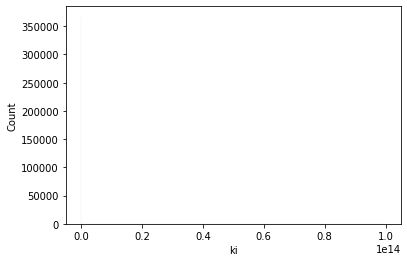

In [ ]:
import seaborn as sns
sns.histplot(x=df_new.ki, bins=1000)
plt.show()

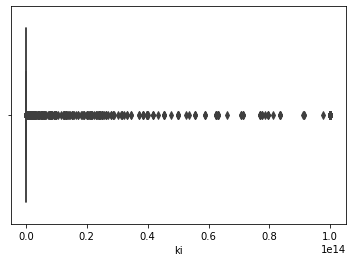

In [ ]:
import seaborn as sns
sns.boxplot(x=df_new.ki)
plt.show()

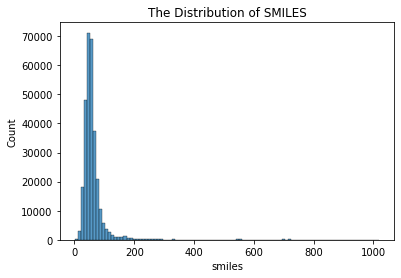

In [ ]:
sns.histplot(x=df_new.smiles.apply(lambda x: len(x)), bins=100)
plt.title('The Distribution of SMILES')
plt.show()

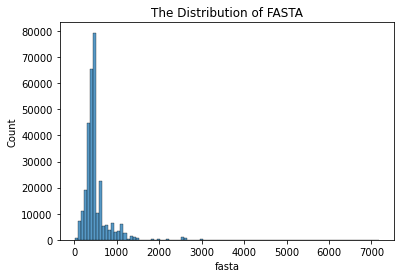

In [ ]:
sns.histplot(x=df_new.fasta.apply(lambda x: len(x)), bins=100)
plt.title('The Distribution of FASTA')
plt.show()

## Explore the 'sweet spot'

count    302357.000000
mean         62.079512
std          51.706206
min           1.000000
25%          42.000000
50%          53.000000
75%          66.000000
max        1019.000000
Name: smiles, dtype: float64

Median: 53.0

80% of the data length is 71
85% of the data length is 76
90% of the data length is 86
95% of the data length is 111


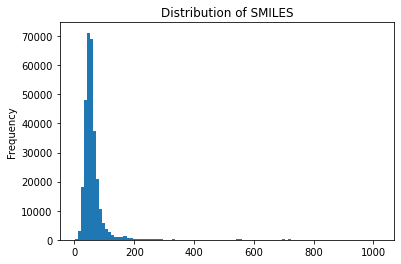

In [ ]:
smiles_dist = df_new.smiles.apply(len)

print(smiles_dist.describe())
print()
print("Median:", smiles_dist.median())
print()
print("80% of the data length is", smiles_dist.quantile(0.8, interpolation='lower'))
print("85% of the data length is", smiles_dist.quantile(0.85, interpolation='lower'))
print("90% of the data length is", smiles_dist.quantile(0.9, interpolation='lower'))
print("95% of the data length is", smiles_dist.quantile(0.95, interpolation='lower'))

smiles_dist.plot(kind='hist', bins=100)
plt.title('Distribution of SMILES')
plt.show()

count    302357.000000
mean        500.364883
std         324.457798
min           9.000000
25%         360.000000
50%         441.000000
75%         505.000000
max        7182.000000
Name: fasta, dtype: float64

Median: 441.0
80% of the data length is 603
85% of the data length is 630
90% of the data length is 838
95% of the data length is 1103


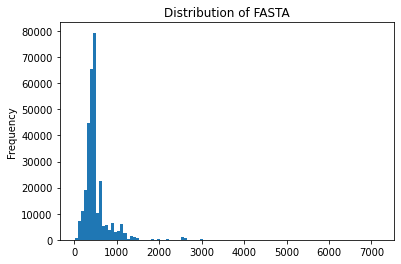

In [ ]:
fasta_dist = df_new.fasta.apply(len)
print(fasta_dist.describe())
print()
print("Median:", fasta_dist.median())
print("80% of the data length is", fasta_dist.quantile(0.8, interpolation='lower'))
print("85% of the data length is", fasta_dist.quantile(0.85, interpolation='lower'))
print("90% of the data length is", fasta_dist.quantile(0.9, interpolation='lower'))
print("95% of the data length is", fasta_dist.quantile(0.95, interpolation='lower'))

fasta_dist.plot(kind='hist', bins=100)
plt.title('Distribution of FASTA')
plt.show()

## Explore the Organism

In [ ]:
df_new = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_no_outlier.tsv', sep='\t')

organism = df_new[(df_new.fasta.apply(len) <= seqlen)]
organism_trunc = df_new[(df_new.fasta.apply(len) > seqlen)]

In [ ]:
not_trunc = organism.organism.unique()
trunc = organism_trunc.organism.unique()

# Intersection
for i in [i for i in not_trunc if i in trunc]:
  print(i)

Homo sapiens
Rattus norvegicus
Bos taurus
Mus musculus
Escherichia coli
Oryctolagus cuniculus
Saccharomyces cerevisiae
Rattus
Porcellium fiumanum
Bacillus subtilis
Clostridium perfringens
Drosophila melanogaster


In [ ]:
# Not Truncated (or 0 Padding on it)
for i in not_trunc:
  print(i)

Human immunodeficiency virus 1
Human immunodeficiency virus
Homo sapiens
nan
Human immunodeficiency virus 2
Influenza B virus (B/Memphis/3/93)
Influenza A virus (strain A/Tokyo/3/1967 H2N2)
Influenza A virus (A/Shangdong/9/1993(H3N2))
Rattus norvegicus
Plasmodium falciparum
Bacillus anthracis
Serratia marcescens
Helicobacter pylori (strain v225d)
Bos taurus
Equus caballus
Mus musculus
Zea mays
Sus scrofa
Electrophorus electricus
Mycobacterium tuberculosis
Canis lupus dingo
Escherichia coli
Staphylococcus aureus
Staphylococcus aureus (strain NCTC 8325)
Streptococcus pneumoniae
Bombyx mori
Lactobacillus casei
Cryptococcus neoformans
Plasmodium vivax
Plasmodium falciparum (isolate K1 / Thailand)
Carica papaya
Cavia porcellus
Methanobacterium thermaggregans
Oryctolagus cuniculus
Human herpesvirus 1
Human herpesvirus 2
Saccharomyces cerevisiae
Trypanosoma brucei brucei
Candida albicans
Cryptococcus neoformans var. grubii
Caenorhabditis elegans
Bacteroides thetaiotaomicron
Francisella tulare

In [ ]:
for i in trunc:
  print(i)

Homo sapiens
Hepatitis C virus genotype 1a (isolate H)
Human SARS coronavirus
Clostridium histolyticum
Rattus norvegicus
Bacillus subtilis
Bos taurus
nan
Mus musculus
Rattus
Porcellium fiumanum
Drosophila melanogaster
Clostridium perfringens
Clostridium botulinum
Dengue virus 2
West Nile virus
Clostridium botulinum (strain Hall / ATCC 3502 / NCTC 13319 / Type A)
Escherichia coli
Saccharomyces cerevisiae
Oryctolagus cuniculus
Plasmodium falciparum (isolate FcB1 / Columbia)


In [ ]:
# Not Available on Not Trunc
for i in [i for i in trunc if i not in not_trunc]:
  print(i)

Hepatitis C virus genotype 1a (isolate H)
Human SARS coronavirus
Clostridium histolyticum
nan
Clostridium botulinum
Dengue virus 2
West Nile virus
Clostridium botulinum (strain Hall / ATCC 3502 / NCTC 13319 / Type A)
Plasmodium falciparum (isolate FcB1 / Columbia)


# Remove Outliers
Using IQR.
$$IQR = Q3 - Q1$$
<BR>
$$Q1 - 1.5 * IQR$$
$$Q3 + 1.5 * IQR$$

In [ ]:
q1 = df_new.ki.quantile(0.25)
q3 = df_new.ki.quantile(0.75)
iqr = q3 - q1
print(q1, q3, iqr)
print(q3 + 1.5 * iqr)

7.8 919.0 911.2
2285.8


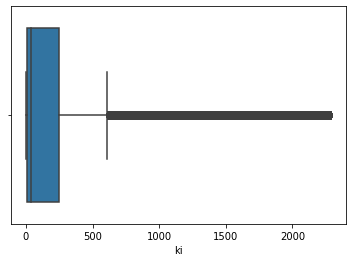

In [ ]:
import seaborn as sns
sns.boxplot(x=df_new[df_new.ki <= q3 + 1.5 * iqr].ki)
plt.show()

In [ ]:
df_new = df_new[df_new.ki <= q3 + 1.5 * iqr]
df_new.shape

(302357, 4)

In [ ]:
print("Mean:", df_new.ki.mean())
print("Median:", df_new.ki.median())
print("STD:", df_new.ki.std())
print("Min:", df_new.ki.min())
print("Max:", df_new.ki.max())

Mean: 240.19684171657036
Median: 36.0
STD: 437.7879597981487
Min: 0.0
Max: 2285.0


In [ ]:
df_new.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_no_outlier.tsv', sep='\t', index=False)

# Sampling the dataset

In [2]:
df_new = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_no_outlier.tsv', sep='\t')
print(df_new.shape)
df_new.head()

(302357, 4)


,smiles,fasta,organism,ki
0,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.24
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.25
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.41
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.80
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.99


In [ ]:
df.organism.value_counts(normalize=True)

Homo sapiens                                                          0.691263
Rattus norvegicus                                                     0.150312
Rattus                                                                0.032772
Mus musculus                                                          0.028467
Bos taurus                                                            0.018480
                                                                        ...   
Haemophilus influenzae                                                0.000004
Fujinami sarcoma virus                                                0.000004
Human T-cell leukemia virus 1 (strain Japan ATK-1 subtype A)          0.000004
Legionella pneumophila                                                0.000004
Haemophilus influenzae (strain ATCC 51907 / DSM 11121 / KW20 / Rd)    0.000004
Name: organism, Length: 152, dtype: float64

### 40K

In [ ]:
df_sampled = df.sample(n=40000, random_state=42)
print(df_sampled.organism.value_counts(normalize=True))
df_sampled.head()

Homo sapiens                                             0.688919
Rattus norvegicus                                        0.152042
Rattus                                                   0.032951
Mus musculus                                             0.028319
Bos taurus                                               0.018200
                                                           ...   
Human herpesvirus 1                                      0.000033
Methanobacterium thermaggregans                          0.000033
Saccharomyces cerevisiae (strain ATCC 204508 / S288c)    0.000033
Enterococcus faecalis                                    0.000033
Macaca mulatta                                           0.000033
Name: organism, Length: 106, dtype: float64


,smiles,fasta,organism,ki
213569,Cc1ccc(cc1C(F)(F)F)S(=O)(=O)N1CCNC(=O)C1CC(=O)...,MASSWPPLELQSSNQSQLFPQNATACDNAPEAWDLLHRVLPTFIIS...,NaN,0.12
273782,C(Nc1nccc2[nH]c3ccccc3c12)c1ccccc1,MALTPESPSSFPGLAATGSSVPEPPGGPNATLNSSWASPTEPSSLE...,Homo sapiens,12.59
215641,Cc1cc2c(N)nc(N)nc2cc1-c1ccccc1,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,Homo sapiens,129.00
157799,Clc1cccc(Cc2nc3c(NCCC4CCCCN4)nccc3o2)c1,MDAMKRGLCCVLLLCGAVFVSPSQEIHARFRRGARSYQVICRDEKT...,Homo sapiens,0.29
79194,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CCC2CCCCC2)CC1,MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCW...,NaN,8.20


In [ ]:
df_sampled.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_40k.tsv', sep='\t', index=False)

### 100k

In [ ]:
df_sampled = df_new.sample(n=100000, random_state=42)
print(df_sampled.organism.value_counts(normalize=True))
print(df_sampled.shape)
df_sampled.head()

Homo sapiens                                    0.690693
Rattus norvegicus                               0.150893
Rattus                                          0.033014
Mus musculus                                    0.027816
Bos taurus                                      0.018378
                                                  ...   
Helicoverpa zea                                 0.000013
Human cytomegalovirus                           0.000013
Vibrio proteolyticus                            0.000013
Acinetobacter baumannii                         0.000013
Influenza A virus (A/Shangdong/9/1993(H3N2))    0.000013
Name: organism, Length: 123, dtype: float64
(100000, 4)


,smiles,fasta,organism,ki
213569,Cc1ccc(cc1C(F)(F)F)S(=O)(=O)N1CCNC(=O)C1CC(=O)...,MASSWPPLELQSSNQSQLFPQNATACDNAPEAWDLLHRVLPTFIIS...,NaN,0.12
273782,C(Nc1nccc2[nH]c3ccccc3c12)c1ccccc1,MALTPESPSSFPGLAATGSSVPEPPGGPNATLNSSWASPTEPSSLE...,Homo sapiens,12.59
215641,Cc1cc2c(N)nc(N)nc2cc1-c1ccccc1,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,Homo sapiens,129.00
157799,Clc1cccc(Cc2nc3c(NCCC4CCCCN4)nccc3o2)c1,MDAMKRGLCCVLLLCGAVFVSPSQEIHARFRRGARSYQVICRDEKT...,Homo sapiens,0.29
79194,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CCC2CCCCC2)CC1,MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCW...,NaN,8.20


In [ ]:
df_sampled.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_100k.tsv', sep='\t', index=False)

### 150k

In [ ]:
df_sampled = df_new.sample(n=150000, random_state=42)
print(df_sampled.organism.value_counts(normalize=True))
print(df_sampled.shape)
df_sampled.head()

Homo sapiens                0.691718
Rattus norvegicus           0.150125
Rattus                      0.032752
Mus musculus                0.028259
Bos taurus                  0.018548
                              ...   
Dicentrarchus labrax        0.000009
Pseudomonas paucimobilis    0.000009
Human cytomegalovirus       0.000009
Lissotriton vulgaris        0.000009
Vibrio proteolyticus        0.000009
Name: organism, Length: 135, dtype: float64
(150000, 4)


,smiles,fasta,organism,ki
213569,Cc1ccc(cc1C(F)(F)F)S(=O)(=O)N1CCNC(=O)C1CC(=O)...,MASSWPPLELQSSNQSQLFPQNATACDNAPEAWDLLHRVLPTFIIS...,NaN,0.12
273782,C(Nc1nccc2[nH]c3ccccc3c12)c1ccccc1,MALTPESPSSFPGLAATGSSVPEPPGGPNATLNSSWASPTEPSSLE...,Homo sapiens,12.59
215641,Cc1cc2c(N)nc(N)nc2cc1-c1ccccc1,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,Homo sapiens,129.00
157799,Clc1cccc(Cc2nc3c(NCCC4CCCCN4)nccc3o2)c1,MDAMKRGLCCVLLLCGAVFVSPSQEIHARFRRGARSYQVICRDEKT...,Homo sapiens,0.29
79194,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CCC2CCCCC2)CC1,MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCW...,NaN,8.20


In [ ]:
df_sampled.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_150k.tsv', sep='\t', index=False)

### 200K

In [ ]:
df_sampled = df_new.sample(n=200000, random_state=42)
print(df_sampled.organism.value_counts(normalize=True))
print(df_sampled.shape)
df_sampled.head()

Homo sapiens                  0.691054
Rattus norvegicus             0.150154
Rattus                        0.032987
Mus musculus                  0.028340
Bos taurus                    0.018528
                                ...   
Human herpesvirus 2           0.000007
Streptomyces coelicolor       0.000007
Bacillus sporothermodurans    0.000007
Bison bison                   0.000007
Dicentrarchus labrax          0.000007
Name: organism, Length: 140, dtype: float64
(200000, 4)


,smiles,fasta,organism,ki
213569,Cc1ccc(cc1C(F)(F)F)S(=O)(=O)N1CCNC(=O)C1CC(=O)...,MASSWPPLELQSSNQSQLFPQNATACDNAPEAWDLLHRVLPTFIIS...,NaN,0.12
273782,C(Nc1nccc2[nH]c3ccccc3c12)c1ccccc1,MALTPESPSSFPGLAATGSSVPEPPGGPNATLNSSWASPTEPSSLE...,Homo sapiens,12.59
215641,Cc1cc2c(N)nc(N)nc2cc1-c1ccccc1,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,Homo sapiens,129.00
157799,Clc1cccc(Cc2nc3c(NCCC4CCCCN4)nccc3o2)c1,MDAMKRGLCCVLLLCGAVFVSPSQEIHARFRRGARSYQVICRDEKT...,Homo sapiens,0.29
79194,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CCC2CCCCC2)CC1,MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCW...,NaN,8.20


In [ ]:
df_sampled.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_200k.tsv', sep='\t', index=False)

### 250K

In [ ]:
df_sampled = df_new.sample(n=250000, random_state=42)
print(df_sampled.organism.value_counts(normalize=True))
print(df_sampled.shape)
df_sampled.head()

Homo sapiens                                                          0.691347
Rattus norvegicus                                                     0.150260
Rattus                                                                0.032735
Mus musculus                                                          0.028312
Bos taurus                                                            0.018606
                                                                        ...   
Mycobacterium tuberculosis H37Rv                                      0.000005
Saccharomyces cerevisiae (strain ATCC 204508 / S288c)                 0.000005
Human herpesvirus 2                                                   0.000005
Luciola lateralis                                                     0.000005
Haemophilus influenzae (strain ATCC 51907 / DSM 11121 / KW20 / Rd)    0.000005
Name: organism, Length: 147, dtype: float64
(250000, 4)


,smiles,fasta,organism,ki
213569,Cc1ccc(cc1C(F)(F)F)S(=O)(=O)N1CCNC(=O)C1CC(=O)...,MASSWPPLELQSSNQSQLFPQNATACDNAPEAWDLLHRVLPTFIIS...,NaN,0.12
273782,C(Nc1nccc2[nH]c3ccccc3c12)c1ccccc1,MALTPESPSSFPGLAATGSSVPEPPGGPNATLNSSWASPTEPSSLE...,Homo sapiens,12.59
215641,Cc1cc2c(N)nc(N)nc2cc1-c1ccccc1,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,Homo sapiens,129.00
157799,Clc1cccc(Cc2nc3c(NCCC4CCCCN4)nccc3o2)c1,MDAMKRGLCCVLLLCGAVFVSPSQEIHARFRRGARSYQVICRDEKT...,Homo sapiens,0.29
79194,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CCC2CCCCC2)CC1,MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCW...,NaN,8.20


In [ ]:
df_sampled.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_250k.tsv', sep='\t', index=False)

### 275K

In [ ]:
df_sampled = df_new.sample(n=275000, random_state=42)
print(df_sampled.organism.value_counts(normalize=True))
print(df_sampled.shape)
df_sampled.head()

Homo sapiens                                                    0.690900
Rattus norvegicus                                               0.150458
Rattus                                                          0.032769
Mus musculus                                                    0.028410
Bos taurus                                                      0.018738
                                                                  ...   
Human T-cell leukemia virus 1 (strain Japan ATK-1 subtype A)    0.000005
Flavobacterium meningosepticum                                  0.000005
Bacillus sporothermodurans                                      0.000005
Pseudomonas paucimobilis                                        0.000005
Equus caballus                                                  0.000005
Name: organism, Length: 149, dtype: float64
(275000, 4)


,smiles,fasta,organism,ki
213569,Cc1ccc(cc1C(F)(F)F)S(=O)(=O)N1CCNC(=O)C1CC(=O)...,MASSWPPLELQSSNQSQLFPQNATACDNAPEAWDLLHRVLPTFIIS...,NaN,0.12
273782,C(Nc1nccc2[nH]c3ccccc3c12)c1ccccc1,MALTPESPSSFPGLAATGSSVPEPPGGPNATLNSSWASPTEPSSLE...,Homo sapiens,12.59
215641,Cc1cc2c(N)nc(N)nc2cc1-c1ccccc1,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...,Homo sapiens,129.00
157799,Clc1cccc(Cc2nc3c(NCCC4CCCCN4)nccc3o2)c1,MDAMKRGLCCVLLLCGAVFVSPSQEIHARFRRGARSYQVICRDEKT...,Homo sapiens,0.29
79194,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CCC2CCCCC2)CC1,MDKLDANVSSEEGFGSVEKVVLLTFLSTVILMAILGNLLVMVAVCW...,NaN,8.20


In [ ]:
df_sampled.to_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_275k.tsv', sep='\t', index=False)

# Preprocess The Dataset For Modelling

## Throw Out The Above-Threshold Observations

In [3]:
df_new = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_no_outlier.tsv', sep='\t')
# df_new = pd.read_csv('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/data_skripsi_fix_275k.tsv', sep='\t')

df_new['smiles'] = df_new.smiles.apply(lambda x: x[:smilen])
df_new['fasta'] = df_new.fasta.apply(lambda x: x[:seqlen])
df_new['fasta'] = df_new.fasta.apply(lambda x: x.upper())

print(df_new.shape)
df_new.head()

(302357, 4)


,smiles,fasta,organism,ki
0,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.24
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.25
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.41
3,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.80
4,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,Human immunodeficiency virus 1,0.99


# Modelling Section

## Scan the unique character 

In [ ]:
# Upper Case The Protein
# df_new['fasta'] = df_new['fasta'].str.upper()

In [ ]:
# RUN ONLY ONCE!
# char_fasta = set(df_new.fasta.unique().sum())
# print(char_fasta)
# print(len(char_fasta))

In [ ]:
# RUN ONLY ONCE!
# char_smiles = set(df_new.smiles.unique().sum())
# print(char_smiles)
# print(len(char_smiles))

In [ ]:
# Unique characters for FASTA
char_fasta = {'V', 'L', 'N', '9', 'M', '8', '7', 'C', 'H', 'P', '4', 'W', '5', '0', '2', 'X', 'Y', 'S', 'E', '3', 'I', 'G', 'A', 'U', '1', 'R', 'F', '6', 'K', 'D', 'T', 'Q'}
code_fasta = {i+1 for i in range(len(char_fasta))}
CHARPROTSET = dict(zip(char_fasta, code_fasta))
print(len(CHARPROTSET))
print(CHARPROTSET)

# Unique characters for SMILES
char_smiles = {'@', ':', 'Z', 'V', 'u', 'L', '.', 'N', 'O', '9', 'd', 'g', 's', 'M', ']', '8', 'c', 'o', 't', '7', 'C', 'H', '-', 'P', '4', 'e', 'a', 'i', '5', '/', '0', '2', '%', 'n', 'S', 'B', '3', 'r', 'I', '#', ')', '=', 'A', '1', '(', 'R', 'b', 'F', 'l', '6', 'K', '[', 'T', '+', '\\'}
code_smiles = {i+1 for i in range(len(char_smiles))}
CHARISOSMISET = dict(zip(char_smiles, code_smiles))
print(len(CHARISOSMISET))
print(CHARISOSMISET)

32
{'0': 1, 'V': 2, '6': 3, 'L': 4, 'F': 5, 'M': 6, 'I': 7, 'D': 8, 'E': 9, '3': 10, '8': 11, '7': 12, '2': 13, 'T': 14, '4': 15, 'R': 16, '9': 17, 'N': 18, 'A': 19, 'H': 20, 'C': 21, 'Q': 22, '1': 23, 'X': 24, '5': 25, 'W': 26, 'K': 27, 'Y': 28, 'S': 29, 'U': 30, 'P': 31, 'G': 32}
55
{'0': 1, 'V': 2, '#': 3, '6': 4, 'L': 5, 'F': 6, 'M': 7, 'I': 8, 'd': 9, '@': 10, '[': 11, '8': 12, 'O': 13, '3': 14, 'r': 15, 'e': 16, '7': 17, '2': 18, 'i': 19, '=': 20, 'T': 21, '4': 22, 'R': 23, '9': 24, ')': 25, '\\': 26, 'N': 27, 'A': 28, 'Z': 29, ']': 30, 'H': 31, 'o': 32, 'u': 33, '1': 34, '.': 35, '(': 36, '/': 37, '5': 38, 'K': 39, 't': 40, 's': 41, '-': 42, 'P': 43, 'c': 44, ':': 45, 'B': 46, 'a': 47, '%': 48, 'n': 49, 'g': 50, 'S': 51, '+': 52, 'b': 53, 'l': 54, 'C': 55}


## Encoding The Sequences

In [4]:
# RUN ONLY ONCE!

# ENCODING FUNCTION
# SMILES
def label_smiles(line, MAX_SMI_LEN, smi_ch_ind):
	X = np.zeros(MAX_SMI_LEN)
	for i, ch in enumerate(line[:MAX_SMI_LEN]): #	x, smi_ch_ind, y
		X[i] = smi_ch_ind[ch]
	return X #.tolist()

# FASTA
def label_sequence(line, MAX_SEQ_LEN, smi_ch_ind):
	X = np.zeros(MAX_SEQ_LEN)
	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = smi_ch_ind[ch]
	return X #.tolist()

# # In case for testing
# sample_smiles = df_trunc.smiles_truncated[0]
# sample_fasta = df_trunc.fasta_truncated[0]
# print("SMILES Encoded:", label_smiles(sample_smiles, 106, CHARISOSMISET))
# print("FASTA Encoded:", label_sequence(sample_fasta, 1118, CHARPROTSET))

XD = []
XT = []
Y = []

# Encode SMILES (XD)
for i in tqdm(df_new.smiles):
  try:
    XD.append(label_smiles(i, smilen, CHARISOSMISET))
  except:
    print("This Sequence is Failed to Encoded")
    print(i)

# Encode FASTA (XT)
for i in tqdm(df_new.fasta):
  try:
    XT.append(label_sequence(i, seqlen, CHARPROTSET))
  except:
    print("This Sequence is Failed to Encoded")
    print(i)

# For Y
for i in tqdm(df_new.ki):
  Y.append(i)

# Set as the np array
XD = np.asarray(XD)
XT = np.asarray(XT)
Y = np.asarray(Y)

# Save as .npy format
np.save('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/XD.npy', XD)
np.save('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/XT.npy', XT)
np.save('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/Y.npy', Y)

100%|██████████| 302357/302357 [00:00<00:00, 2124402.89it/s]


## Load the Array

In [2]:
# # In case using sample
# XD = np.load('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/XD275.npy')
# XT = np.load('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/XT275.npy')
# Y = np.load('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/Y275.npy')

XD = np.load('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/XD.npy')
XT = np.load('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/XT.npy')
Y = np.load('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/data/Y.npy')

Y_temp = Y

Y_log = Y_temp
Y_log[np.where(Y == 0.)[0]] = 1e-10
Y_log = -np.log10(Y_log * 1e-9)
Y = Y_log

In [6]:
from scipy.stats import skew

print(skew(Y_temp))
print(skew(Y_log))
# print(skew(Y_box))

2.484726751650674
0.6440512568871144


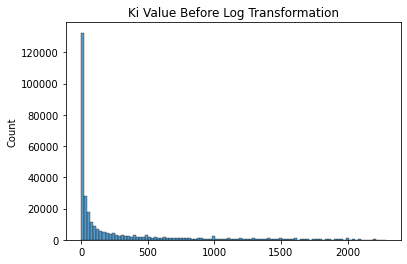

In [7]:
import seaborn as sns
sns.histplot(x=Y_temp, bins=100)
plt.title('Ki Value Before Log Transformation')
plt.show()

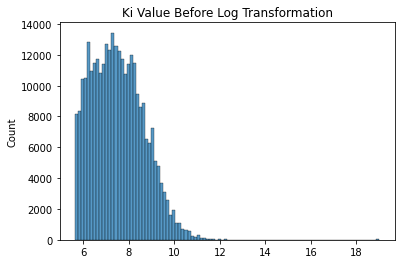

In [8]:
sns.histplot(x=Y_log, bins=100)
plt.title('Ki Value Before Log Transformation')
plt.show()

## Helper Function

In [3]:
def plotLoss(history, param1ind, param2ind, param3ind, foldind):
    figname = "win"+str(param1ind) + "_smi" + str(param2ind) + "_seq" + str(param3ind) + "_fold"  + str(foldind) + "_" + str(time.time()) 
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['trainloss', 'valloss'], loc='upper left')
    plt.savefig("/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/Visualization Result/" + figname + ".png" , dpi=None, facecolor='w', edgecolor='w', orientation='portrait', 
                    papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)
    plt.close()

    ## PLOT CINDEX
    plt.figure()
    plt.title('Model Concordance Index')
    plt.ylabel('cindex')
    plt.xlabel('epoch')
    plt.plot(history.history['cindex_score'])
    plt.plot(history.history['val_cindex_score'])
    plt.legend(['traincindex', 'valcindex'], loc='upper left')
    plt.savefig("/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/Visualization Result/"+ figname + "_acc.png" , dpi=None, facecolor='w', edgecolor='w', orientation='portrait', 
                            papertype=None, format=None,transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)
    plt.close()

  
def cindex_score(y_true, y_pred):
    g = tf.subtract(tf.expand_dims(y_pred, -1), y_pred)
    g = tf.cast(g == 0.0, tf.float32) * 0.5 + tf.cast(g > 0.0, tf.float32)
    f = tf.subtract(tf.expand_dims(y_true, -1), y_true) > 0.0
    f = tf.compat.v1.matrix_band_part(tf.cast(f, tf.float32), -1, 0)
    g = tf.reduce_sum(tf.multiply(g, f))
    f = tf.reduce_sum(f)

    return tf.where(tf.equal(g, 0), 0.0, g/f) #select

# def get_cindex(Y, P):
#     summ = 0
#     pair = 0
#     for i in range(1, len(Y)):
#         for j in range(0, i):
#             if i is not j:
#                 if(Y[i] > Y[j]):
#                     pair += 1
#                     summ += 1 * (P[i] > P[j]) + 0.5 * (P[i] == P[j])
#     if pair is not 0:
#         return summ/pair
#     else:
#         return 0

## The Model

In [ ]:
def build_combined_categorical(NUM_FILTERS, FILTER_LENGTH1, FILTER_LENGTH2):
    XDinput = Input(shape=(smilen,), dtype='int32', name='drug_input')
    XTinput = Input(shape=(seqlen,), dtype='int32', name='target_input')

    # SMILES 
    encode_smiles = Embedding(input_dim=charsmiset_size+1, output_dim=128, input_length=smilen, name='drug_embedding')(XDinput) 
    encode_smiles = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1, name='drug_conv_1')(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1, name='drug_conv_2')(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH1,  activation='relu', padding='valid',  strides=1, name='drug_conv_3')(encode_smiles)
    encode_smiles = GlobalMaxPooling1D(name='drug_max_pooling')(encode_smiles)

    # FASTA
    encode_protein = Embedding(input_dim=charseqset_size+1, output_dim=128, input_length=seqlen, name='target_embedding')(XTinput)
    encode_protein = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1, name='target_conv_1')(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1, name='target_conv_2')(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH2,  activation='relu', padding='valid',  strides=1, name='target_conv_3')(encode_protein)
    encode_protein = GlobalMaxPooling1D(name='target_max_pooling')(encode_protein)

    # Concat
    encode_interaction = keras.layers.concatenate([encode_smiles, encode_protein], axis=-1) #merge.Add()([encode_smiles, encode_protein])

    # FC 
    FC1 = Dense(1024, activation='relu', name='fc_1')(encode_interaction)
    FC2 = Dropout(0.1)(FC1)
    FC2 = Dense(1024, activation='relu', name='fc_2')(FC2)
    FC2 = Dropout(0.1)(FC2)
    FC2 = Dense(512, activation='relu', name='fc_3')(FC2)

    # And add a logistic regression on top
    predictions = Dense(1, kernel_initializer='normal', name='prediction')(FC2) #OR no activation, rght now it's between 0-1, do I want this??? activation='sigmoid'

    interactionModel = Model(inputs=[XDinput, XTinput], outputs=[predictions])
    interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score]) #, metrics=['cindex_score']
    print(interactionModel.summary())
    plot_model(interactionModel, to_file='/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/Visualization Result/build_combined_categorical.png')

    return interactionModel

## Hyperparameter Tuning (ABORT)

In [ ]:
since = time.time()

train_fold = []
val_fold = []
test_fold = []

# NOTE: First 5 Fold for Hyperparameter Tuning. The remaining will be used for final evaluation.
n_fold = 6
kf = KFold(n_splits=n_fold)

for train_idx, test_idx in kf.split(XD):
  train_fold.append(train_idx)
  val_fold.append(test_idx)

# Hyperparameters
num_windows = [16, 32, 64, 128, 512]
smi_window_lengths = [4, 6, 8]
seq_window_lengths = [4, 8, 12]
epoch = 100
batch_size = 256

w = len(val_fold) - 1
h = len(num_windows) * len(smi_window_lengths) * len(seq_window_lengths)

all_predictions = [[0 for x in range(w)] for y in range(h)]
all_losses = [[0 for x in range(w)] for y in range(h)]

# Cross Validation x Hyperparameter Tuning
for i in range(len(val_fold) - 1):
  train_idx = train_fold[i]
  val_idx = val_fold[i]
  # TRAIN DATASET
  XD_train = XD[train_idx]
  XT_train = XT[train_idx]
  Y_train = Y[train_idx]
  # VAL DATASET
  XD_val = XD[val_idx]
  XT_val = XT[val_idx]
  Y_val = Y[val_idx]

  pointer = 0
  
  for j, num_window in enumerate(num_windows):
    for k, smi_length in enumerate(smi_window_lengths):
      for l, seq_length in enumerate(seq_window_lengths):                    
        # Initialize the model
        gridmodel = build_combined_categorical(num_window, smi_length, seq_length)
        # Early Stopping
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
        # Fit the model
        gridres = gridmodel.fit(([XD_train, XT_train]), np.array(Y_train), batch_size=batch_size, epochs=epoch,
                                validation_data=( ([XD_val, XT_val]), np.array(Y_val) ), shuffle=False, callbacks=[es]) 
        # Predict the label
        Y_pred = gridmodel.predict([XD_val, XT_val])
        # Evaluate the result
        loss, rperf2 = gridmodel.evaluate(([XD_val, XT_val]), np.array(Y_val), verbose=0)
        rperf = get_cindex(Y_val, Y_pred)
        rperf = rperf[0]
        # logging("P1 = %d,  P2 = %d, P3 = %d, Fold = %d, CI-i = %f, CI-ii = %f, MSE = %f" % (i, j, k, l, rperf, rperf2, loss), FLAGS)
        # Visualize the loss
        plotLoss(gridres, num_window, smi_length, seq_length, i)

        all_predictions[pointer][i] = rperf #TODO FOR EACH VAL SET allpredictions[pointer][foldind]
        all_losses[pointer][i] = loss

        pointer +=1

# Choosing the best hyperparameter
bestperf = -float('Inf')
bestpointer = None
best_param_list = []
pointer = 0
for j, num_window in enumerate(num_windows):
  for k, smi_length in enumerate(smi_window_lengths):
    for l, seq_length in enumerate(seq_window_lengths): 
      avgperf = 0.
      for foldind in range(len(val_sets) - 1):
          foldperf = all_predictions[pointer][foldind]
          avgperf += foldperf
      avgperf /= len(val_fold) - 1
      #print(epoch, batchsz, avgperf)
      if avgperf > bestperf:
          bestperf = avgperf
          bestpointer = pointer
          best_param_list = [num_window, smi_length, seq_length]
      pointer += 1

final_time = time.time() - since
print(final_time)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drug_input (InputLayer)         [(None, 106)]        0                                            
__________________________________________________________________________________________________
target_input (InputLayer)       [(None, 1118)]       0                                            
__________________________________________________________________________________________________
drug_embedding (Embedding)      (None, 106, 128)     7168        drug_input[0][0]                 
__________________________________________________________________________________________________
target_embedding (Embedding)    (None, 1118, 128)    4224        target_input[0][0]               
______________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drug_input (InputLayer)         [(None, 106)]        0                                            
__________________________________________________________________________________________________
target_input (InputLayer)       [(None, 1118)]       0                                            
__________________________________________________________________________________________________
drug_embedding (Embedding)      (None, 106, 128)     7168        drug_input[0][0]                 
__________________________________________________________________________________________________
target_embedding (Embedding)    (None, 1118, 128)    4224        target_input[0][0]               
____________________________________________________________________________________________

KeyboardInterrupt: ignored

## Modelling Using The Best Hyperparameter (According To The Writer)

### Training From Scratch

In [ ]:
def build_combined_categorical(NUM_FILTERS, FILTER_LENGTH1, FILTER_LENGTH2):
    XDinput = Input(shape=(smilen,), dtype='int32', name='drug_input')
    XTinput = Input(shape=(seqlen,), dtype='int32', name='target_input')

    # SMILES 
    encode_smiles = Embedding(input_dim=charsmiset_size+1, output_dim=128, input_length=smilen, name='drug_embedding')(XDinput) 
    encode_smiles = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH1 + 2,  activation='relu', padding='valid',  strides=1, name='drug_conv_1')(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH1 + 2,  activation='relu', padding='valid',  strides=1, name='drug_conv_2')(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH1 + 2,  activation='relu', padding='valid',  strides=1, name='drug_conv_3')(encode_smiles)
    encode_smiles = GlobalMaxPooling1D(name='drug_max_pooling')(encode_smiles)

    # FASTA
    encode_protein = Embedding(input_dim=charseqset_size+1, output_dim=128, input_length=seqlen, name='target_embedding')(XTinput)
    encode_protein = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH2 + 4,  activation='relu', padding='valid',  strides=1, name='target_conv_1')(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH2 + 4,  activation='relu', padding='valid',  strides=1, name='target_conv_2')(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH2 + 4,  activation='relu', padding='valid',  strides=1, name='target_conv_3')(encode_protein)
    encode_protein = GlobalMaxPooling1D(name='target_max_pooling')(encode_protein)

    # Concat
    encode_interaction = keras.layers.concatenate([encode_smiles, encode_protein], axis=-1) #merge.Add()([encode_smiles, encode_protein])

    # FC 
    FC1 = Dense(1024, activation='relu', name='fc_1')(encode_interaction)
    FC2 = Dropout(0.1)(FC1)
    FC2 = Dense(1024, activation='relu', name='fc_2')(FC2)
    FC2 = Dropout(0.1)(FC2)
    FC2 = Dense(512, activation='relu', name='fc_3')(FC2)

    # And add a logistic regression on top
    predictions = Dense(1, kernel_initializer='normal', name='prediction')(FC2) #OR no activation, rght now it's between 0-1, do I want this??? activation='sigmoid'

    interactionModel = Model(inputs=[XDinput, XTinput], outputs=[predictions])
    interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score]) #, metrics=['cindex_score']
    print(interactionModel.summary())
    plot_model(interactionModel, to_file='/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/Visualization Result/build_combined_categorical.png')

    return interactionModel


since = time.time()

train_fold = []
val_fold = []
test_fold = []

# NOTE: First 5 Fold for Hyperparameter Tuning. The remaining will be used for final evaluation.
n_fold = 6
kf = KFold(n_splits=n_fold)

for train_idx, test_idx in kf.split(XD):
  train_fold.append(train_idx)
  val_fold.append(test_idx)

epoch = 100
batch_size = 256

train_idx = train_fold[5]
val_idx = val_fold[5]
# TRAIN DATASET
XD_train = XD[train_idx]
XT_train = XT[train_idx]
Y_train = Y[train_idx]
# VAL DATASET
XD_val = XD[val_idx]
XT_val = XT[val_idx]
Y_val = Y[val_idx]

pointer = 0
                    
# Initialize the model
model = build_combined_categorical(32, 4, 4)
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
# Fit the model
gridres = model.fit(([XD_train, XT_train]), np.array(Y_train), batch_size=batch_size, epochs=epoch,
                        validation_data=(([XD_val, XT_val]), np.array(Y_val)), shuffle=False, callbacks=[es]) 
# Predict the label
Y_pred = model.predict([XD_val, XT_val])
# Evaluate the result
loss, rperf2 = model.evaluate(([XD_val, XT_val]), np.array(Y_val), verbose=0)
rperf = concordance_index(Y_val, Y_pred)

# logging("P1 = %d,  P2 = %d, P3 = %d, Fold = %d, CI-i = %f, CI-ii = %f, MSE = %f" % (i, j, k, l, rperf, rperf2, loss), FLAGS)
# Visualize the loss
plotLoss(gridres, 32, 4, 4, 0)

model.save('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/model/')

print(loss, rperf)

final_time = time.time() - since
print(final_time)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drug_input (InputLayer)         [(None, 95)]         0                                            
__________________________________________________________________________________________________
target_input (InputLayer)       [(None, 1000)]       0                                            
__________________________________________________________________________________________________
drug_embedding (Embedding)      (None, 95, 128)      7168        drug_input[0][0]                 
__________________________________________________________________________________________________
target_embedding (Embedding)    (None, 1000, 128)    4224        target_input[0][0]               
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


NameError: ignored

In [ ]:
model.save('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/model/v1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/model/v1/assets


### Re-Use The Model

In [ ]:
since = time.time()

train_fold = []
val_fold = []
test_fold = []

# NOTE: First 5 Fold for Hyperparameter Tuning. The remaining will be used for final evaluation.
n_fold = 6
kf = KFold(n_splits=n_fold)

for train_idx, test_idx in kf.split(XD):
  train_fold.append(train_idx)
  val_fold.append(test_idx)

epoch = 100
batch_size = 256

train_idx = train_fold[5]
val_idx = val_fold[5]
# TRAIN DATASET
XD_train = XD[train_idx]
XT_train = XT[train_idx]
Y_train = Y[train_idx]
# VAL DATASET
XD_val = XD[val_idx]
XT_val = XT[val_idx]
Y_val = Y[val_idx]

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/model/v1', compile=False)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score])
model.evaluate(([XD_val, XT_val]), np.array(Y_val), verbose=0)

[0.6463804244995117, 0.7656819820404053]

In [ ]:
Y_pred = model.predict([XD_val, XT_val])
rperf = concordance_index(Y_val, Y_pred)
print(rperf)

0.7658196711655052


## Hyperparameter Tuning

In [4]:
train_fold = []
val_fold = []
test_fold = []

# NOTE: First 5 Fold for Hyperparameter Tuning. The remaining will be used for final evaluation.
n_fold = 6
kf = KFold(n_splits=n_fold)

for train_idx, test_idx in kf.split(XD):
  train_fold.append(train_idx)
  val_fold.append(test_idx)

batch_size = 256

for i in range(6):
  print(train_fold[i], val_fold[i])

[ 50393  50394  50395 ... 302354 302355 302356] [    0     1     2 ... 50390 50391 50392]
[     0      1      2 ... 302354 302355 302356] [ 50393  50394  50395 ... 100783 100784 100785]
[     0      1      2 ... 302354 302355 302356] [100786 100787 100788 ... 151176 151177 151178]
[     0      1      2 ... 302354 302355 302356] [151179 151180 151181 ... 201569 201570 201571]
[     0      1      2 ... 302354 302355 302356] [201572 201573 201574 ... 251962 251963 251964]
[     0      1      2 ... 251962 251963 251964] [251965 251966 251967 ... 302354 302355 302356]


### Training From Scratch

In [5]:
def build_combined_categorical(NUM_FILTERS, FILTER_LENGTH1, FILTER_LENGTH2):
    XDinput = Input(shape=(smilen,), dtype='int32', name='drug_input')
    XTinput = Input(shape=(seqlen,), dtype='int32', name='target_input')

    # SMILES 
    encode_smiles = Embedding(input_dim=charsmiset_size+1, output_dim=128, input_length=smilen, name='drug_embedding')(XDinput) 
    encode_smiles = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH1 + 2,  activation='relu', padding='valid',  strides=1, name='drug_conv_1')(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH1 + 2,  activation='relu', padding='valid',  strides=1, name='drug_conv_2')(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH1 + 2,  activation='relu', padding='valid',  strides=1, name='drug_conv_3')(encode_smiles)
    encode_smiles = GlobalMaxPooling1D(name='drug_max_pooling')(encode_smiles)

    # FASTA
    encode_protein = Embedding(input_dim=charseqset_size+1, output_dim=128, input_length=seqlen, name='target_embedding')(XTinput)
    encode_protein = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH2 + 4,  activation='relu', padding='valid',  strides=1, name='target_conv_1')(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*2, kernel_size=FILTER_LENGTH2 + 4,  activation='relu', padding='valid',  strides=1, name='target_conv_2')(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*3, kernel_size=FILTER_LENGTH2 + 4,  activation='relu', padding='valid',  strides=1, name='target_conv_3')(encode_protein)
    encode_protein = GlobalMaxPooling1D(name='target_max_pooling')(encode_protein)

    # Concat
    encode_interaction = keras.layers.concatenate([encode_smiles, encode_protein], axis=-1) #merge.Add()([encode_smiles, encode_protein])

    # FC 
    FC1 = Dense(1024, activation='relu', name='fc_1')(encode_interaction)
    FC2 = Dropout(0.1)(FC1)
    FC2 = Dense(1024, activation='relu', name='fc_2')(FC2)
    FC2 = Dropout(0.1)(FC2)
    FC2 = Dense(512, activation='relu', name='fc_3')(FC2)

    # And add a logistic regression on top
    predictions = Dense(1, kernel_initializer='normal', name='prediction')(FC2) #OR no activation, rght now it's between 0-1, do I want this??? activation='sigmoid'

    interactionModel = Model(inputs=[XDinput, XTinput], outputs=[predictions])
    interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=[cindex_score]) #, metrics=['cindex_score']
    print(interactionModel.summary())
    plot_model(interactionModel, to_file='/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/Visualization Result/build_combined_categorical.png')

    return interactionModel


since = time.time()

# pointer = 0
train_idx = train_fold[0]
val_idx = val_fold[0]
# TRAIN DATASET
XD_train = XD[train_idx]
XT_train = XT[train_idx]
Y_train = Y[train_idx]
# VAL DATASET
XD_val = XD[val_idx]
XT_val = XT[val_idx]
Y_val = Y[val_idx]

# Initialize the model
model = build_combined_categorical(16, 4, 4)
# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
# Fit the model
gridres = model.fit(([XD_train, XT_train]), np.array(Y_train), batch_size=batch_size, epochs=30,
                        validation_data=(([XD_val, XT_val]), np.array(Y_val)), shuffle=False, callbacks=[es]) 
# Predict the label
Y_pred = model.predict([XD_val, XT_val])
# Evaluate the result
loss, rperf2 = model.evaluate(([XD_val, XT_val]), np.array(Y_val), verbose=0)
rperf = concordance_index(Y_val, Y_pred)

# logging("P1 = %d,  P2 = %d, P3 = %d, Fold = %d, CI-i = %f, CI-ii = %f, MSE = %f" % (i, j, k, l, rperf, rperf2, loss), FLAGS)
# Visualize the loss
# plotLoss(gridres, 32, 4, 4, 0)

# model.save('/content/drive/MyDrive/!!!RESEARCHHHHH/Skripsi/asset/model/')

print("MSE: ", loss)
print("CI: ", rperf)

final_time = time.time() - since
print(final_time)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drug_input (InputLayer)         [(None, 95)]         0                                            
__________________________________________________________________________________________________
target_input (InputLayer)       [(None, 1000)]       0                                            
__________________________________________________________________________________________________
drug_embedding (Embedding)      (None, 95, 128)      7168        drug_input[0][0]                 
__________________________________________________________________________________________________
target_embedding (Embedding)    (None, 1000, 128)    4224        target_input[0][0]               
______________________________________________________________________________________________

## Final Evaluation

In [ ]:
def nfold_1_2_3_setting_sample(XD, XT,  Y, label_row_inds, label_col_inds, measure, runmethod,  FLAGS, dataset):
    bestparamlist = []
    test_set, outer_train_sets = dataset.read_sets(FLAGS) 
    
    foldinds = len(outer_train_sets)

    ## TRAIN AND VAL
    val_sets = []
    train_sets = []
    test_sets = []

    #logger.info('Start training')
    for val_foldind in range(foldinds):
        val_fold = outer_train_sets[val_foldind]
        val_sets.append(val_fold)
        otherfolds = deepcopy(outer_train_sets)
        otherfolds.pop(val_foldind)
        otherfoldsinds = [item for sublist in otherfolds for item in sublist]
        train_sets.append(otherfoldsinds)
        test_sets.append(test_set)
        print("val set", str(len(val_fold)))
        print("train set", str(len(otherfoldsinds)))

    bestparamind, best_param_list, bestperf, all_predictions_not_need, losses_not_need = general_nfold_cv(XD, XT, Y, label_row_inds, label_col_inds, measure, runmethod, FLAGS, train_sets, val_sets)
   
    #print("Test Set len", str(len(test_set)))
    #print("Outer Train Set len", str(len(outer_train_sets)))
    bestparam, best_param_list, bestperf, all_predictions, all_losses = general_nfold_cv(XD, XT, Y, label_row_inds, label_col_inds, measure, runmethod, FLAGS, train_sets, test_sets)
    
    testperf = all_predictions[bestparamind]##pointer pos 

    logging("---FINAL RESULTS-----", FLAGS)
    logging("best param index = %s,  best param = %.5f" % 
            (bestparamind, bestparam), FLAGS)

    testperfs = []
    testloss= []

    avgperf = 0.

    for test_foldind in range(len(test_sets)):
        foldperf = all_predictions[bestparamind][test_foldind]
        foldloss = all_losses[bestparamind][test_foldind]
        testperfs.append(foldperf)
        testloss.append(foldloss)
        avgperf += foldperf

    avgperf = avgperf / len(test_sets)
    avgloss = np.mean(testloss)
    teststd = np.std(testperfs)

    logging("Test Performance CI", FLAGS)
    logging(testperfs, FLAGS)
    logging("Test Performance MSE", FLAGS)
    logging(testloss, FLAGS)

    return avgperf, avgloss, teststd

## Test with SARS-CoV-2 and HerbalDB